<a href="https://colab.research.google.com/github/sudhanshu2/propagate-alerts/blob/master/simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alert Propagation on EdgeSys

In [20]:
NUMBER_SENSORS = 1000
SENSORS_CONNECTED = 10

SERVER_COLOR = "#01579B"
SENSOR_COLOR = "#33691E"

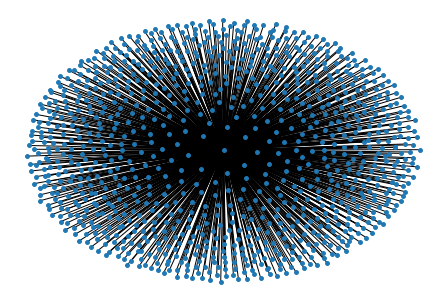

In [21]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

G_cur = nx.star_graph(NUMBER_SENSORS)
nx.draw(G_cur, node_size=15)

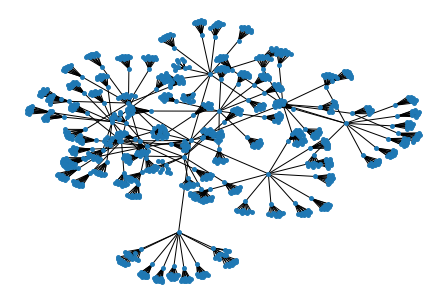

In [ ]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from math import log

G_alert = nx.Graph()

for i in range(NUMBER_SENSORS):
  G_alert.add_node(i)

for i in range(1, SENSORS_CONNECTED + 1):
  G_alert.add_edge(0, i)

current_node = 1
current_difference = SENSORS_CONNECTED

while current_node + current_difference <= NUMBER_SENSORS:
  for i in range(SENSORS_CONNECTED - 1):
    to_join = current_node + current_difference + i
    G_alert.add_edge(current_node, to_join)
  current_node += 1
  current_difference += SENSORS_CONNECTED - 2
  
nx.draw(G_alert, node_size=15)

In [22]:
import networkx as nx

from bokeh.io import output_file, show, output_notebook
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral4
from bokeh.models.graphs import from_networkx

output_notebook()

# Prepare Data
G = G_alert

plot = Plot(plot_width=400, plot_height=400,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))

plot.add_tools(BoxZoomTool(), ResetTool())
graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#000000", line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)

show(plot)